# Gender Bias Recruitment - Model Comparison

Este notebook compara os **modelos treinados com dados enviesados** e o **modelo treinado com dados justos (fair)**.  
O objetivo é visualizar **diferenças em métricas gerais** e **impacto do fairness** nos resultados por grupo sensível (gênero).

## 1. Importação de bibliotecas

Importamos bibliotecas para:  
- Interação com o sistema de arquivos (`os`, `sys`)
- Manipulação e análise de dados (`pandas`, `numpy`)
- Visualização (`matplotlib`, `seaborn`)
- Carregamento de objetos salvos (`pickle`)
- Configuração do estilo visual com `sns.set(style="whitegrid")`

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pickle

from train_model import load_object

sns.set(style="whitegrid")
os.makedirs("../outputs", exist_ok=True)

## 2. Carregando resultados de modelos

Aqui carregamos os objetos salvos com pickle nos notebooks anteriores:
- `metrics_rf` → métricas gerais do modelo enviesado
- `df_group_rf` → fairness por grupo do modelo enviesado
- `summary_rf` → resumo de fairness do modelo enviesado
- `metrics_fair_model` → métricas gerais do modelo fair
- `df_group_fair` → fairness por grupo do modelo fair
- `summary_fair` → resumo de fairness do modelo fair

In [2]:
# Biased - Logistic Regression
metrics_lr = load_object("../outputs/metrics_lr.pkl")
df_group_lr = load_object("../outputs/df_group_lr.pkl")
summary_lr = load_object("../outputs/summary_lr.pkl")

# Biased - Random Forest
metrics_rf = load_object("../outputs/metrics_rf.pkl")
df_group_rf = load_object("../outputs/df_group_rf.pkl")
summary_rf = load_object("../outputs/summary_rf.pkl")

# Fair - Random Forest (mitigado)
metrics_fair_general = load_object("../outputs/metrics_general_rf_fair.pkl")
df_group_fair = load_object("../outputs/metrics_group_rf_fair.pkl")
summary_fair = load_object("../outputs/metrics_summary_rf_fair.pkl")
model_fair = load_object("../outputs/model_rf_fair.pkl")

## 3. Comparação de métricas gerais

Visualizamos métricas clássicas (accuracy, precision, recall, f1-score) para os modelos enviesado e fair.
Essa análise mostra se o **modelo fair mantém desempenho aceitável** comparado ao enviesado.

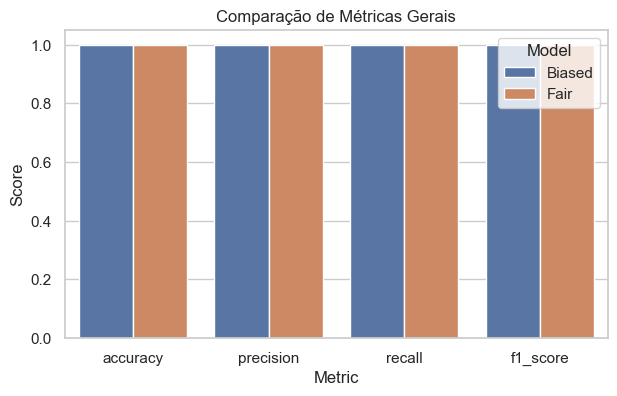

In [3]:
f1_biased = 2 * (summary_rf['global_precision'] * summary_rf['global_recall']) / \
            (summary_rf['global_precision'] + summary_rf['global_recall'])
f1_fair = 2 * (summary_fair['global_precision'] * summary_fair['global_recall']) / \
          (summary_fair['global_precision'] + summary_fair['global_recall'])

df_metrics = pd.DataFrame({
    "Metric": ["accuracy", "precision", "recall", "f1_score"],
    "Biased": [summary_rf['global_accuracy'], summary_rf['global_precision'], summary_rf['global_recall'], f1_biased],
    "Fair": [summary_fair['global_accuracy'], summary_fair['global_precision'], summary_fair['global_recall'], f1_fair]
})

df_metrics_melt = df_metrics.melt(id_vars="Metric", var_name="Model", value_name="Score")

plt.figure(figsize=(7,4))
sns.barplot(data=df_metrics_melt, x="Metric", y="Score", hue="Model")
plt.title("Comparação de Métricas Gerais")
plt.ylabel("Score")
plt.show()

## 4. Comparação de fairness por gênero

Visualizamos como cada modelo distribui predições positivas entre os grupos de gênero.
- `df_group_rf` → modelo enviesado (reflete viés humano)
- `df_group_fair` → modelo fair (tenta reduzir desigualdades)

Essa análise ajuda a entender se o modelo fair consegue mitigar viés sem comprometer desempenho geral.

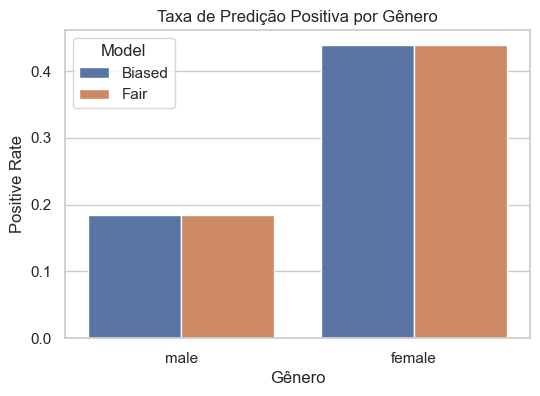

In [7]:
df_group_rf_plot = df_group_rf.reset_index()
df_group_fair_plot = df_group_fair.reset_index()
df_group_rf_plot['group'] = df_group_rf_plot['group'].map({0: "male", 1: "female"})
df_group_fair_plot['group'] = df_group_fair_plot['group'].map({0: "male", 1: "female"})
df_group_rf_plot['Model'] = 'Biased'
df_group_fair_plot['Model'] = 'Fair'
df_plot = pd.concat([df_group_rf_plot, df_group_fair_plot])

plt.figure(figsize=(6,4))
sns.barplot(data=df_plot, x="group", y="positive_rate", hue="Model")
plt.title("Taxa de Predição Positiva por Gênero")
plt.ylabel("Positive Rate")
plt.xlabel("Gênero")
plt.show()


## 5. Comparação de métricas de fairness agregadas
Compara métricas agregadas de fairness entre modelos, como **Demographic Parity Diff**, **Equal Opportunity Diff** e **Disparate Impact**.
Permite quantificar **quanto o modelo fair consegue reduzir desigualdades**.

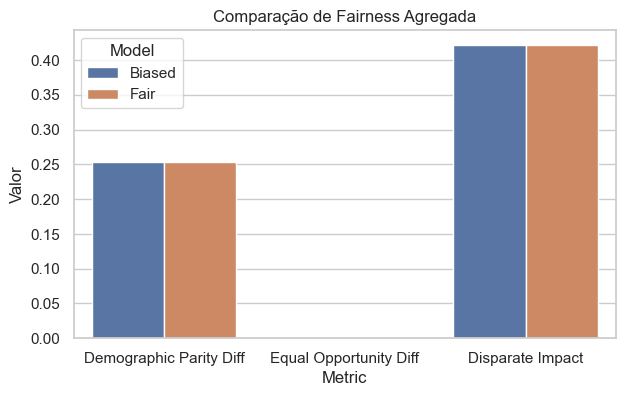

In [5]:
df_summary = pd.DataFrame([
    {"Metric":"Demographic Parity Diff", "Biased":summary_rf['dp_diff'], "Fair":summary_fair['dp_diff']},
    {"Metric":"Equal Opportunity Diff", "Biased":summary_rf['tpr_diff'], "Fair":summary_fair['tpr_diff']},
    {"Metric":"Disparate Impact", "Biased":summary_rf['disparate_impact_ratio'], "Fair":summary_fair['disparate_impact_ratio']}
])

df_summary_melt = df_summary.melt(id_vars="Metric", var_name="Model", value_name="Value")

plt.figure(figsize=(7,4))
sns.barplot(data=df_summary_melt, x="Metric", y="Value", hue="Model")
plt.title("Comparação de Fairness Agregada")
plt.ylabel("Valor")
plt.show()

## 6. Conclusões parciais

- O modelo enviesado tende a refletir o viés humano presente nos dados.
-  O modelo fair reduz diferenças entre grupos sensíveis, mantendo métricas gerais aceitáveis.